In [1]:
from sys import executable
!{executable} -m pip install -U numpy pandas seaborn matplotlib sklearn graphviz nltk scipy

In [2]:
import numpy as np
import pandas as pd

import graphviz
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import spatial
from statistics import mean
from scipy.cluster import hierarchy as sch

from nltk import word_tokenize, pos_tag
from nltk.translate import bleu_score
from nltk.translate.bleu_score import corpus_bleu

from sklearn import tree
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics.pairwise import paired_cosine_distances

import re
import string
import pickle

from glob import glob

/usr/local/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from nltk import download
download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mvshmakovmv/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
%matplotlib inline
sns.set(context='notebook', style='darkgrid')
pd.set_option('display.float_format', lambda x: f'{x :.2f}')
plt.rcParams['figure.figsize'] = (20.0, 10.0)

In [6]:
base_dir = "./"

# Reading dataset

In [7]:
def get_df_from_csvs_in_path(d):
    all_files = glob(d + "/*.csv")
    df_list = [pd.read_csv(filename, index_col=None, header=0, sep=';') for filename in all_files]

    return pd.concat(df_list, axis=0, ignore_index=True)

In [8]:
blogs_processed_dir = base_dir + 'data/blogs/processed/'

df = get_df_from_csvs_in_path(blogs_processed_dir)
df['joined_edus'] = df.EDU_1 + ' ' + df.EDU_2

df.dropna(inplace=True)
df

,EDU_1,EDU_2,Relation,joined_edus
0,"После поездки в 2017 на Бали я вспомнил, что о...","поэтому в 2018 полетели снова в теплые края, н...",cause_r,"После поездки в 2017 на Бали я вспомнил, что о..."
1,"поэтому в 2018 полетели снова в теплые края, н...","есть, что посмотреть.",preparation_r,"поэтому в 2018 полетели снова в теплые края, н..."
2,(только сейчас руки дошли написать!).,"поэтому в 2018 полетели снова в теплые края, н...",evaluation_r,(только сейчас руки дошли написать!). поэтому ...
3,"В общем, прекрасное место!","поэтому в 2018 полетели снова в теплые края, н...",evaluation_r,"В общем, прекрасное место! поэтому в 2018 поле..."
4,"Остров не маленький,","есть, что посмотреть.",cause_r,"Остров не маленький, есть, что посмотреть."
...,...,...,...,...
11752,и примерно такой же будет всегда.,она такая сейчас,sequence_m,и примерно такой же будет всегда. она такая се...
11753,Надеяться уже в принципе не на что.,"Это неотъемлемые свойства платформы,",joint_m,Надеяться уже в принципе не на что. Это неотъе...
11754,"И не то чтобы у меня было для вас что-то получше,",Надеяться уже в принципе не на что.,elaboration_r,И не то чтобы у меня было для вас что-то получ...
11755,"или что я могу сказать, где будущее.","И не то чтобы у меня было для вас что-то получше,",joint_m,"или что я могу сказать, где будущее. И не то ч..."


In [9]:
df.describe()

,EDU_1,EDU_2,Relation,joined_edus
count,11736,11736,11736,11736
unique,11643,6383,18,11730
top,[код],"Встать ровно,",joint_m,Боль Боль
freq,9,23,2502,2


# Feature extractors

In [10]:
features = ['num_of_words', 'avg_word_len', 'upcase_words_num', 'pos_tags', 'tf_idf']

In [11]:
test_edu = 'Современные технологии достигли такого уровня, что современная методология разработки создаёт предпосылки для позиций.'
test_edu_2 = 'Лишь базовые сценарии поведения пользователей, превозмогая сложившуюся непростую экономическую ситуацию.'

In [12]:
num_of_words = lambda edus: len(edus.split())
num_of_words(test_edu)

13

In [13]:
avg_word_len = lambda edus: mean([len(word) for word in edus.split()])
avg_word_len(test_edu)

8.153846153846153

In [14]:
upcase_words_num = lambda edus: len([word for word in edus.split() if word.istitle()])
upcase_words_num(test_edu)

1

In [15]:
def pos_tags(edus):
    pos_tags = []

    for word in edus.split():
        word = word.lower()
        tokenized = word_tokenize(word)
        pos_tags.append(pos_tag(tokenized))

    return pos_tags

pos_tags(test_edu)

[[('современные', 'NN')],
 [('технологии', 'NN')],
 [('достигли', 'NN')],
 [('такого', 'NN')],
 [('уровня', 'NN'), (',', ',')],
 [('что', 'NN')],
 [('современная', 'NN')],
 [('методология', 'NN')],
 [('разработки', 'NN')],
 [('создаёт', 'NN')],
 [('предпосылки', 'NN')],
 [('для', 'NN')],
 [('позиций', 'NN'), ('.', '.')]]

In [16]:
def tf_idf(edus):
    tfidf_vectorizer = TfidfVectorizer(lowercase=True, stop_words=None, use_idf=True,
                                       smooth_idf=False, preprocessor=lambda edus: re.sub(r"[{}]".format(string.punctuation), " ", edus))
    return tfidf_vectorizer.fit_transform(edus.split())

print(tf_idf(test_edu))

  (0, 0)	1.0
  (1, 10)	1.0
  (2, 2)	1.0
  (3, 9)	1.0
  (4, 11)	1.0
  (5, 12)	1.0
  (6, 7)	1.0
  (7, 3)	1.0
  (8, 6)	1.0
  (9, 8)	1.0
  (10, 5)	1.0
  (11, 1)	1.0
  (12, 4)	1.0


In [17]:
morph_correlation = lambda row, row_2: spatial.distance.correlation(row.split(), row_2.split())
morph_canberra = lambda row, row_2: spatial.distance.canberra(row.split(), row_2.split())
morph_hamming = lambda row: spatial.distance.hamming(row.split(), row_2.split())
morph_matching = lambda row: spatial.distance.get_match_between_vectors_(row.split(), row_2.split())

# morph_correlation(test_edu, test_edu_2)

In [18]:
def ang_cos_tf_idf_sim(tf_idf_x, tf_idf_y):
    cos_dist = paired_cosine_distances(tf_idf_x, tf_idf_y)
    np.arccos(cos_dist) * 2. / np.pi

# ang_cos_tf_idf_sim(tf_idf_x, tf_idf_y)

In [19]:
get_bleu_score = lambda row, row_2: bleu_score.sentence_bleu([row], row_2, weights=(0.5,))
get_bleu_score(test_edu, test_edu_2)

0.7808356939911968

# Features extraction

In [20]:
def apply_bleu(columns):
    return get_bleu_score(columns[0], columns[1])

def extract_features(target_df):
    target_df['num_of_words'] = target_df.joined_edus.apply(num_of_words)
    target_df['avg_word_len'] = target_df.joined_edus.apply(avg_word_len)
    target_df['upcase_words_num'] = target_df.joined_edus.apply(upcase_words_num)
    target_df['bleu_score'] = list(map(apply_bleu, zip(target_df['EDU_1'], target_df['EDU_2'])))
    return target_df

extract_features(df)

,EDU_1,EDU_2,Relation,joined_edus,num_of_words,avg_word_len,upcase_words_num,bleu_score
0,"После поездки в 2017 на Бали я вспомнил, что о...","поэтому в 2018 полетели снова в теплые края, н...",cause_r,"После поездки в 2017 на Бали я вспомнил, что о...",31,4.52,4,0.54
1,"поэтому в 2018 полетели снова в теплые края, н...","есть, что посмотреть.",preparation_r,"поэтому в 2018 полетели снова в теплые края, н...",15,5.00,2,0.10
2,(только сейчас руки дошли написать!).,"поэтому в 2018 полетели снова в теплые края, н...",evaluation_r,(только сейчас руки дошли написать!). поэтому ...,17,5.24,2,0.63
3,"В общем, прекрасное место!","поэтому в 2018 полетели снова в теплые края, н...",evaluation_r,"В общем, прекрасное место! поэтому в 2018 поле...",16,4.94,3,0.56
4,"Остров не маленький,","есть, что посмотреть.",cause_r,"Остров не маленький, есть, что посмотреть.",6,6.17,1,0.72
...,...,...,...,...,...,...,...,...
11752,и примерно такой же будет всегда.,она такая сейчас,sequence_m,и примерно такой же будет всегда. она такая се...,9,4.67,0,0.29
11753,Надеяться уже в принципе не на что.,"Это неотъемлемые свойства платформы,",joint_m,Надеяться уже в принципе не на что. Это неотъе...,11,5.64,2,0.69
11754,"И не то чтобы у меня было для вас что-то получше,",Надеяться уже в принципе не на что.,elaboration_r,И не то чтобы у меня было для вас что-то получ...,18,3.78,2,0.54
11755,"или что я могу сказать, где будущее.","И не то чтобы у меня было для вас что-то получше,",joint_m,"или что я могу сказать, где будущее. И не то ч...",18,3.83,1,0.70


# Data preprocessing

In [21]:
rels_to_classify = []

def preprocess(target_df):
    global rels_to_classify

    # We need to bound the amount of available classes and memoize it
    if (len(rels_to_classify) == 0):
        counts = target_df.Relation.value_counts().loc[lambda x: x > 500]
        rels_to_classify = list(target_df.Relation[counts.index].index)
    target_df = target_df.loc[target_df.Relation.isin(rels_to_classify)]

    # Encoding categorical Relation varible
    target_df.Relation = LabelEncoder().fit_transform(target_df.Relation)
    
    # Drop categorical varibles
    categorical = target_df.select_dtypes(include=['object']).columns
    target_df.drop(columns=categorical, inplace=True)

    # MinMaxScaler scaling
    cols_without_relation = target_df.columns[target_df.columns != 'Relation']
    target_df[cols_without_relation] = MinMaxScaler().fit_transform(target_df[cols_without_relation])

    target_df.dropna(inplace=True)
    
    return target_df

In [22]:
df = preprocess(df)
rels_to_classify

['joint_m',
 'elaboration_r',
 'contrast_m',
 'cause_r',
 'evaluation_r',
 'condition_r',
 'sequence_m',
 'preparation_r']

In [23]:
df

,Relation,num_of_words,avg_word_len,upcase_words_num,bleu_score
0,0,0.28,0.21,0.04,0.54
1,6,0.12,0.25,0.02,0.10
2,4,0.14,0.27,0.02,0.63
3,4,0.13,0.24,0.03,0.56
4,0,0.04,0.34,0.01,0.72
...,...,...,...,...,...
11752,7,0.07,0.22,0.00,0.29
11753,5,0.09,0.30,0.02,0.69
11754,3,0.15,0.15,0.02,0.54
11755,5,0.15,0.15,0.01,0.70


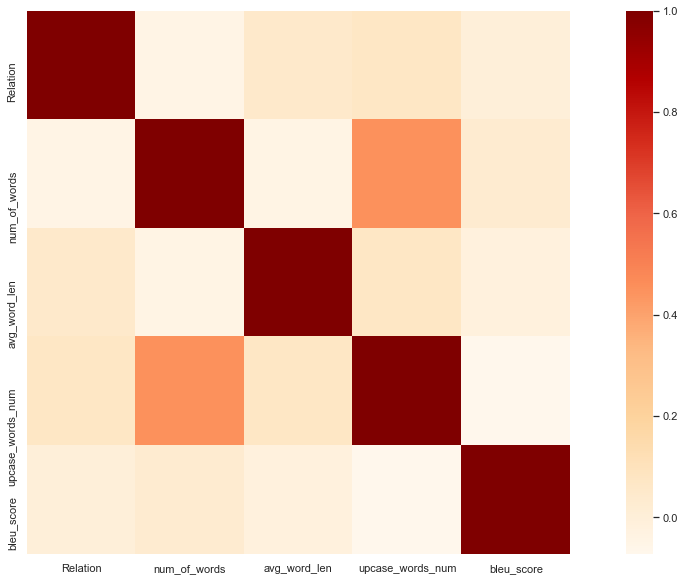

In [24]:
sns.heatmap(df.corr(), square = True, cmap='OrRd')

In [25]:
X = df.drop(columns=['Relation'])
y = df.Relation

In [26]:
X

,num_of_words,avg_word_len,upcase_words_num,bleu_score
0,0.28,0.21,0.04,0.54
1,0.12,0.25,0.02,0.10
2,0.14,0.27,0.02,0.63
3,0.13,0.24,0.03,0.56
4,0.04,0.34,0.01,0.72
...,...,...,...,...
11752,0.07,0.22,0.00,0.29
11753,0.09,0.30,0.02,0.69
11754,0.15,0.15,0.02,0.54
11755,0.15,0.15,0.01,0.70


In [27]:
y

0        0
1        6
2        4
3        4
4        0
        ..
11752    7
11753    5
11754    3
11755    5
11756    2
Name: Relation, Length: 9822, dtype: int64

# Classification

In [28]:
kf = KFold(n_splits=5, shuffle=True, random_state=2020)

def train_and_verify(model):
    scores = []

    for train, test in kf.split(X):
        X_train, X_test, y_train, y_test = X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        scores.append(accuracy_score(y_test, y_pred))

    print(f'Mean from scores: {np.mean(scores):.2f}')
    print(f'Std from scores: {np.std(scores):.2f}')
    
    return scores

# Decision Tree Classifier 

In [29]:
dt_cls = DecisionTreeClassifier(max_depth=7)
train_and_verify(dt_cls)

Mean from scores: 0.29
Std from scores: 0.01


[0.29974554707379136,
 0.2748091603053435,
 0.3095723014256619,
 0.2846232179226069,
 0.2785132382892057]

In [30]:
predicted = dt_cls.predict(X)
cm = confusion_matrix(y, predicted)

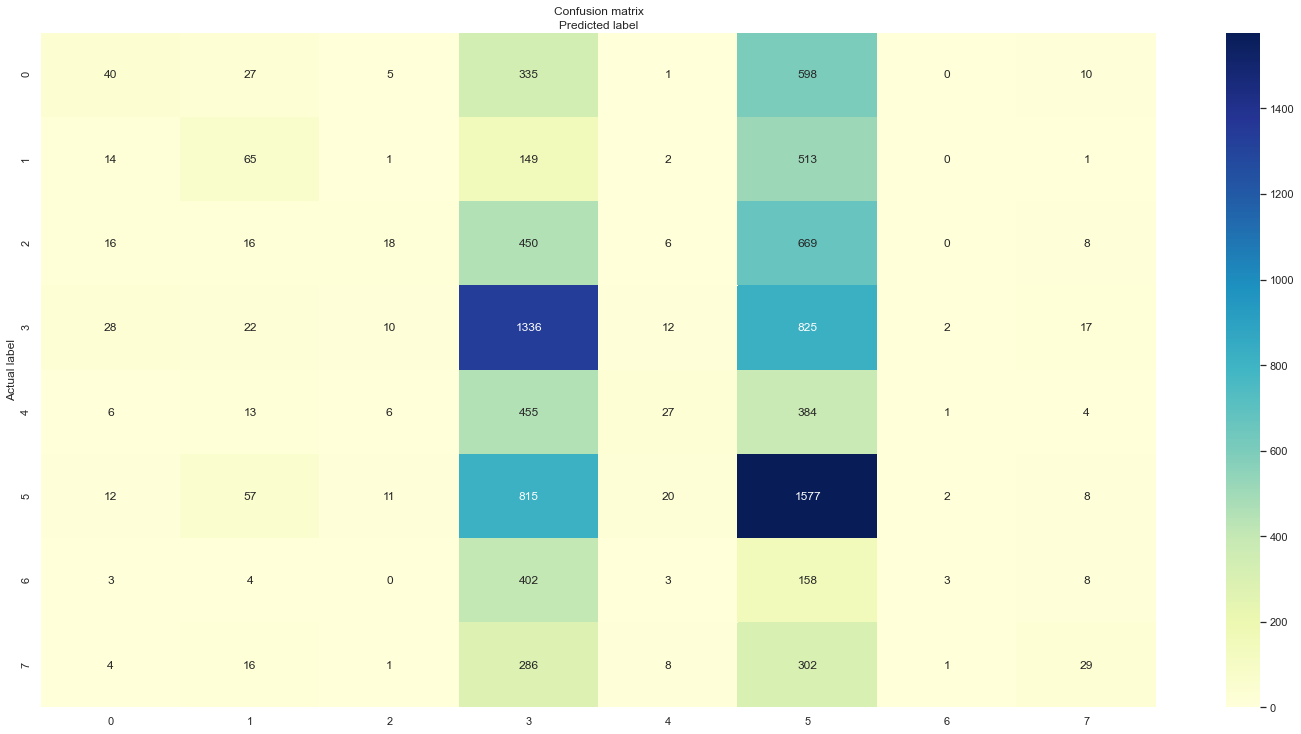

In [31]:
names = [0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(names))

plt.xticks(tick_marks, names)
plt.yticks(tick_marks, names)

sns.heatmap(cm, annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position('top')

plt.tight_layout()
plt.title('Confusion matrix', y = 1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [32]:
pickle.dump(dt_cls, open('classifiers/dt_cls.pkl', 'wb'))

# SVM

In [33]:
svm_cls = SVC(kernel='linear')
train_and_verify(svm_cls)

Mean from scores: 0.28
Std from scores: 0.02


[0.2972010178117048,
 0.2498727735368957,
 0.29480651731160895,
 0.27342158859470467,
 0.2836048879837067]

In [34]:
predicted = svm_cls.predict(X)
cm = confusion_matrix(y, predicted)

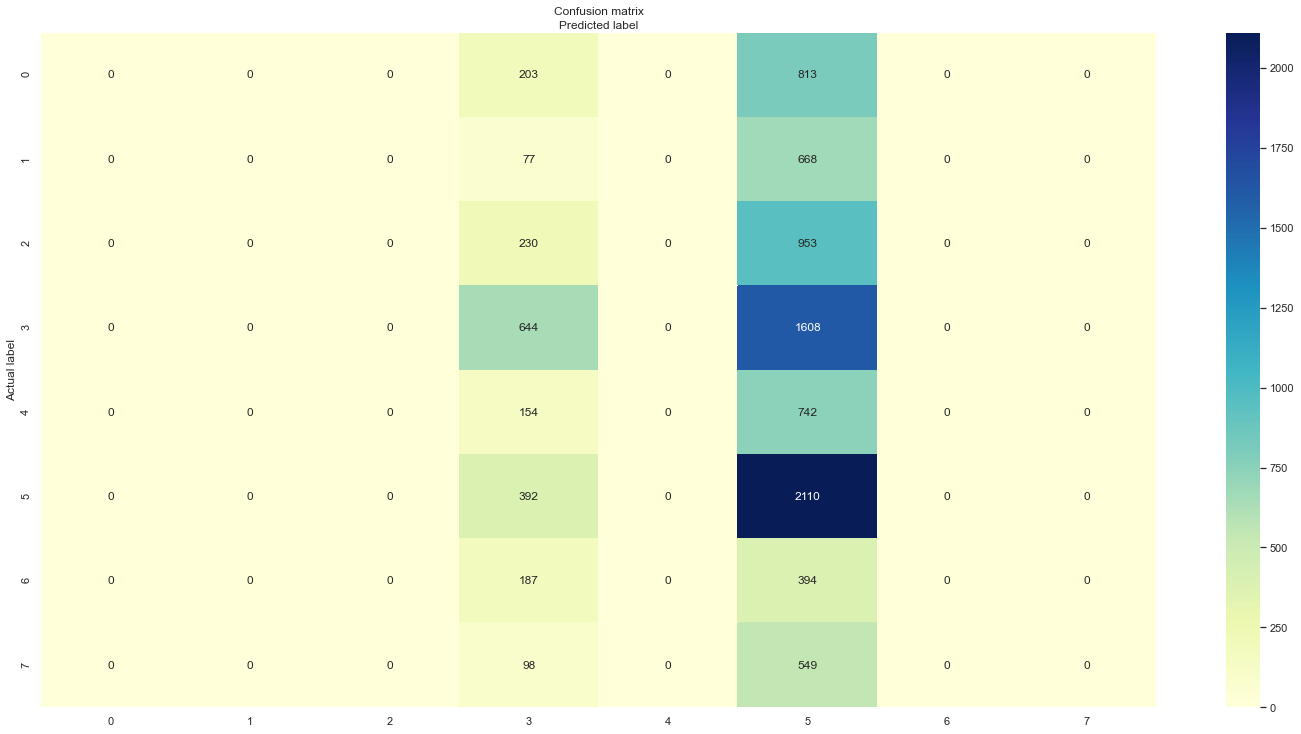

In [35]:
names = [0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(names))

plt.xticks(tick_marks, names)
plt.yticks(tick_marks, names)

sns.heatmap(cm, annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position('top')

plt.tight_layout()
plt.title('Confusion matrix', y = 1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [36]:
pickle.dump(svm_cls, open('classifiers/svm_cls.pkl', 'wb'))

# Gaussian Naive Bayes

In [37]:
gnb_cls = GaussianNB()
train_and_verify(gnb_cls)

Mean from scores: 0.27
Std from scores: 0.01


[0.2865139949109415,
 0.24681933842239187,
 0.280040733197556,
 0.26629327902240324,
 0.28105906313645623]

In [38]:
predicted = gnb_cls.predict(X)
cm = confusion_matrix(y, predicted)

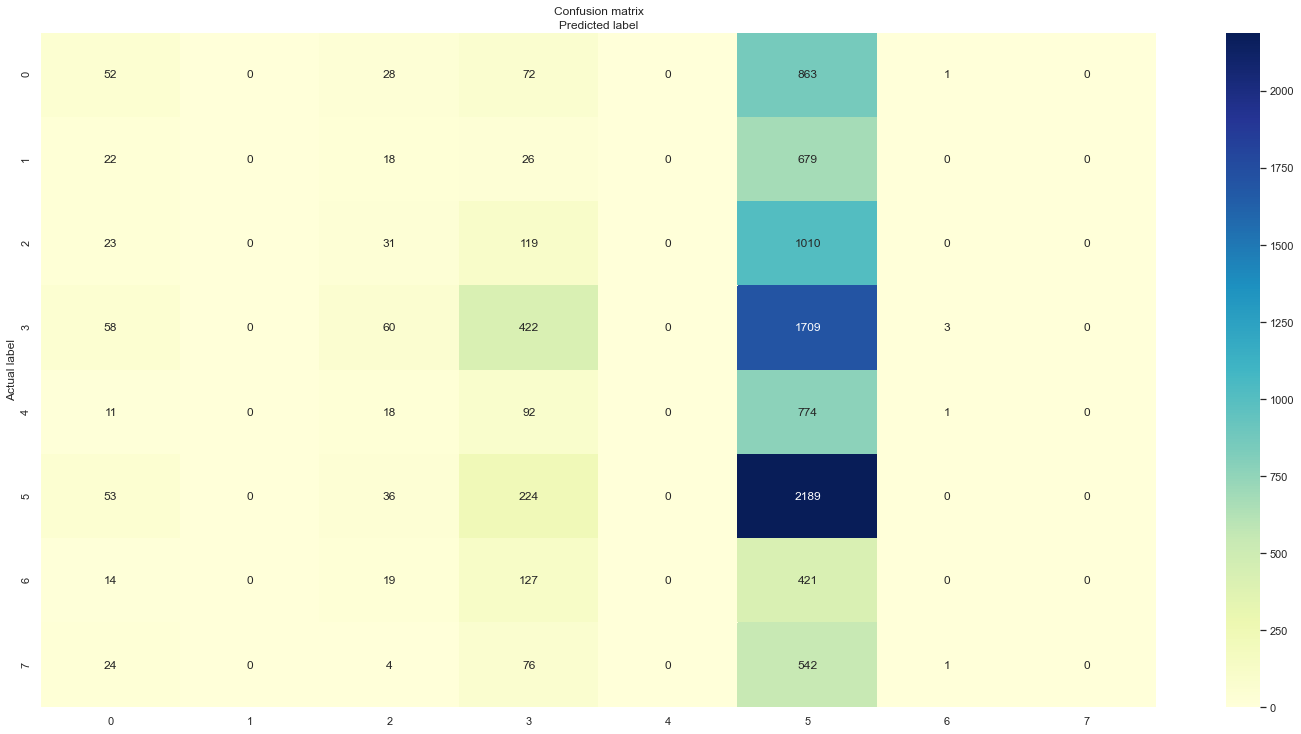

In [39]:
names = [0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(names))

plt.xticks(tick_marks, names)
plt.yticks(tick_marks, names)

sns.heatmap(cm, annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position('top')

plt.tight_layout()
plt.title('Confusion matrix', y = 1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [40]:
pickle.dump(gnb_cls, open('classifiers/gnb_cls.pkl', 'wb'))

# Classification on schizo dataset

In [41]:
schizo_processed_dir = base_dir + 'data/schizo/schizo/processed/'
schizo_healthy_processed_dir = base_dir + 'data/schizo/healthy/processed/'

df_healthy = get_df_from_csvs_in_path(schizo_processed_dir)
df_schizo = get_df_from_csvs_in_path(schizo_healthy_processed_dir)

df_healthy['joined_edus'] = df_healthy.EDU_1 + ' ' + df_healthy.EDU_2
df_schizo['joined_edus'] = df_schizo.EDU_1 + ' ' + df_schizo.EDU_2

df_healthy.dropna(inplace=True)
df_schizo.dropna(inplace=True)

In [42]:
df_healthy

,EDU_1,EDU_2,Relation,joined_edus
0,где-нибудь в предгорьях на Кавказе,действие происходит где-нибудь на юге там,elaboration_r,где-нибудь в предгорьях на Кавказе действие пр...
1,либо в средней азии,действие происходит где-нибудь на юге там,contrast_m,либо в средней азии действие происходит где-ни...
2,который груши собирает,мужчина лет сорока пяти там,elaboration_r,который груши собирает мужчина лет сорока пяти...
3,взял лестницу,мужчина лет сорока пяти там,joint_m,взял лестницу мужчина лет сорока пяти там
4,по лестнице на дерево там,мужчина лет сорока пяти там,elaboration_r,по лестнице на дерево там мужчина лет сорока п...
...,...,...,...,...
309,который собирал груши 20,человек 19,elaboration_r,который собирал груши 20 человек 19
310,спустился с лестницы 19,человек 19,joint_m,спустился с лестницы 19 человек 19
311,он заметил 21,что не хватает корзины 22,evidence_r,он заметил 21 что не хватает корзины 22
312,что не хватает корзины 22,человек 19,antithesis_r,что не хватает корзины 22 человек 19


In [43]:
df_schizo

,EDU_1,EDU_2,Relation,joined_edus
0,ну я б сказала 1,не очень правдоподобная история 2,evaluation_r,ну я б сказала 1 не очень правдоподобная истор...
1,не очень правдоподобная история 2,человек собирает груши 15,antithesis_r,не очень правдоподобная история 2 человек соби...
2,потому что этот человек 3,не очень правдоподобная история 2,cause_r,потому что этот человек 3 не очень правдоподоб...
3,убирающий собирающий груши 4,потому что этот человек 3,elaboration_r,убирающий собирающий груши 4 потому что этот ч...
4,наверняка он все-таки звук слышит хорошо 5,потому что этот человек 3,joint_m,наверняка он все-таки звук слышит хорошо 5 пот...
...,...,...,...,...
544,он их за это угостил грушами вот 47,но это самое а шляпа-то у него улетела тоже 43,result_r,он их за это угостил грушами вот 47 но это сам...
545,это то есть мальчик такой ну благодарный 48,вот поехал дальше 42,antithesis_r,это то есть мальчик такой ну благодарный 48 во...
546,будем говорить да 49,это то есть мальчик такой ну благодарный 48,antithesis_r,будем говорить да 49 это то есть мальчик такой...
547,вот ну и в общем повёз это всё домой помощник 50,вот поехал дальше 42,sequence_m,вот ну и в общем повёз это всё домой помощник ...


In [44]:
df_healthy = extract_features(df_healthy)
df_schizo = extract_features(df_schizo)

df_healthy = preprocess(df_healthy)
df_schizo = preprocess(df_schizo)

In [45]:
df_healthy

,Relation,num_of_words,avg_word_len,upcase_words_num,bleu_score
0,2,0.44,0.75,1.00,0.96
1,1,0.38,0.55,0.00,0.77
2,2,0.25,0.59,0.00,0.87
3,4,0.19,0.50,0.00,0.69
4,2,0.38,0.35,0.00,0.98
...,...,...,...,...,...
304,6,0.44,0.14,0.00,0.93
305,6,0.31,0.22,0.00,0.90
308,6,0.38,0.22,0.00,0.48
309,2,0.12,0.50,0.00,0.18


In [46]:
df_schizo

,Relation,num_of_words,avg_word_len,upcase_words_num,bleu_score
0,4,0.26,0.51,0.00,0.63
2,0,0.26,0.75,0.00,0.77
3,3,0.22,0.78,0.00,0.45
4,5,0.35,0.68,0.00,0.46
5,0,0.43,0.54,0.00,0.82
...,...,...,...,...,...
539,7,0.13,0.48,0.00,0.45
540,7,0.43,0.44,0.00,0.26
542,7,0.61,0.49,0.00,0.88
543,7,0.39,0.44,0.00,0.56


In [47]:
X_healthy = df_healthy.drop(columns=['Relation'])
y_healthy = df_healthy.Relation

In [48]:
X_schizo = df_schizo.drop(columns=['Relation'])
y_schizo = df_schizo.Relation

In [49]:
print(f"SVM healthy accuracy: {accuracy_score(y_healthy, svm_cls.predict(X_healthy))}")
print(f"Decision Tree Classifier healthy accuracy: {accuracy_score(y_healthy, dt_cls.predict(X_healthy))}")
print(f"Gaussian Naive Bayes healthy accuracy: {accuracy_score(y_healthy, gnb_cls.predict(X_healthy))}")

SVM healthy accuracy: 0.03125
Decision Tree Classifier healthy accuracy: 0.08854166666666667
Gaussian Naive Bayes healthy accuracy: 0.03125


In [50]:
print(f"SVM schizo accuracy: {accuracy_score(y_schizo, svm_cls.predict(X_schizo))}")
print(f"Decision Tree Classifier schizo accuracy: {accuracy_score(y_schizo, dt_cls.predict(X_schizo))}")
print(f"Gaussian Naive Bayes schizo accuracy: {accuracy_score(y_schizo, gnb_cls.predict(X_schizo))}")

SVM schizo accuracy: 0.14506172839506173
Decision Tree Classifier schizo accuracy: 0.08333333333333333
Gaussian Naive Bayes schizo accuracy: 0.11728395061728394
